In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
)

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import RandomForestClassifier

In [18]:
np.random.seed(42)
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(["boat", "body", "home.dest"], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [19]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
999,3,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0,0,383123,7.7500,NaN,Q
392,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1,0,SC/PARIS 2167,27.7208,NaN,C
628,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
1165,3,"Saad, Mr. Khalil",male,25.0,0,0,2672,7.2250,NaN,C
604,3,"Abelseth, Miss. Karen Marie",female,16.0,0,0,348125,7.6500,NaN,S


In [20]:
X_train.isnull().any()

pclass      False
name        False
sex         False
age          True
sibsp       False
parch       False
ticket      False
fare         True
cabin        True
embarked    False
dtype: bool

In [21]:
X_train.isnull().sum()

pclass        0
name          0
sex           0
age         209
sibsp         0
parch         0
ticket        0
fare          1
cabin       822
embarked      0
dtype: int64

In [22]:
# import missingno as msno
# import matplotlib.pyplot as plt
# msno.matrix(X_train)
# plt.show()

In [23]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         19.961796
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.095511
cabin       78.510029
embarked     0.000000
dtype: float64

In [24]:
X_train.drop(["cabin"], axis=1, inplace=True)
X_test.drop(["cabin"], axis=1, inplace=True)

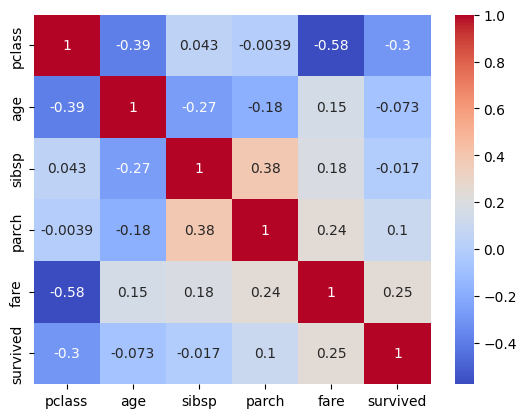

In [25]:
import pandas as pd
import seaborn as sns

X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(
    X_comb[["pclass", "sex", "age", "sibsp", "parch", "fare", "survived"]].corr(
        numeric_only=True
    ),
    annot=True,
    cmap="coolwarm",
)

In [26]:
for dataset in [X_train, X_test]:
    dataset["family_size"] = dataset["parch"] + dataset["sibsp"]
    dataset.drop(["parch", "sibsp"], axis=1, inplace=True)
    dataset["is_alone"] = 1
    dataset["is_alone"].loc[dataset["family_size"] > 1] = 0
X_train.head()

C:\Users\sigma\AppData\Local\Temp\ipykernel_11852\2185609536.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset["is_alone"].loc[dataset["family_size"] > 1] = 0
C:\Users\sigma\AppData\Local\Temp\ipykernel_11852\2185609536.py:5: Setti

,pclass,name,sex,age,ticket,fare,embarked,family_size,is_alone
999,3,"McCarthy, Miss. Catherine 'Katie'",female,NaN,383123,7.7500,Q,0,1
392,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,SC/PARIS 2167,27.7208,C,1,1
628,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,347082,31.2750,S,6,0
1165,3,"Saad, Mr. Khalil",male,25.0,2672,7.2250,C,0,1
604,3,"Abelseth, Miss. Karen Marie",female,16.0,348125,7.6500,S,0,1


In [27]:
for dataset in [X_train, X_test]:
    dataset["title"] = (
        dataset["name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    )
    dataset.drop(["name"], axis=1, inplace=True)
X_train.head()

,pclass,sex,age,ticket,fare,embarked,family_size,is_alone,title
999,3,female,NaN,383123,7.7500,Q,0,1,Miss
392,2,female,24.0,SC/PARIS 2167,27.7208,C,1,1,Mrs
628,3,female,11.0,347082,31.2750,S,6,0,Miss
1165,3,male,25.0,2672,7.2250,C,0,1,Mr
604,3,female,16.0,348125,7.6500,S,0,1,Miss


In [28]:
pd.crosstab(X_train["title"], X_train["sex"])

sex,female,male
title,,
Capt,0,1
Col,0,3
Don,0,1
Dona,1,0
Dr,0,6
Major,0,1
Master,0,51
Miss,210,0
Mlle,2,0


In [29]:
print(
    f"Miss: {np.sum(y_train.astype(int)[X_train.title == 'Miss']) / len(X_train.title == 'Miss')}"
)
print(
    f"Mrs: {np.sum(y_train.astype(int)[X_train.title == 'Mrs']) / len(X_train.title == 'Mrs')}"
)

Miss: 0.13371537726838587
Mrs: 0.1174785100286533


In [30]:
X_comb = pd.concat([X_train, X_test])
rare_titles = X_comb["title"].value_counts() < 10
rare_titles

title
Mr              False
Miss            False
Mrs             False
Master          False
Rev              True
Dr               True
Col              True
Ms               True
Major            True
Mlle             True
Don              True
the Countess     True
Capt             True
Dona             True
Lady             True
Mme              True
Sir              True
Jonkheer         True
Name: count, dtype: bool

In [31]:
for dataset in [X_train, X_test]:
    dataset.title.loc[dataset.title == "Miss"] = "Mrs"
    dataset["title"] = dataset.title.apply(lambda x: "rare" if rare_titles[x] else x)

C:\Users\sigma\AppData\Local\Temp\ipykernel_11852\2037860971.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset.title.loc[dataset.title == "Miss"] = "Mrs"
C:\Users\sigma\AppData\Local\Temp\ipykernel_11852\2037860971.py:2: SettingWit

In [32]:
for dataset in [X_train, X_test]:
    dataset.drop("ticket", axis=1, inplace=True)

X_train.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,title
999,3,female,NaN,7.7500,Q,0,1,Mrs
392,2,female,24.0,27.7208,C,1,1,Mrs
628,3,female,11.0,31.2750,S,6,0,Mrs
1165,3,male,25.0,7.2250,C,0,1,Mr
604,3,female,16.0,7.6500,S,0,1,Mrs


## Scikit-Learn

In [33]:
X_train.dtypes

pclass            int64
sex            category
age             float64
fare            float64
embarked       category
family_size       int64
is_alone          int64
title            object
dtype: object

In [34]:
def get_cat_cols(df):
    obj_cols = df.columns[df.dtypes == "object"]
    cat_cols = df.columns[df.dtypes == "category"]
    return set(obj_cols).union(set(cat_cols))


cat_cols = get_cat_cols(X_train)
cat_cols

{'embarked', 'sex', 'title'}

In [35]:
cat_cols = ["embarked", "sex", "pclass", "title", "is_alone"]
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ("pca", PCA(n_components=10)),
    ]
)

In [36]:
cat_transformer[0]

SimpleImputer(strategy='most_frequent')

In [37]:
num_cols = ["age", "fare", "family_size"]
num_transformer = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", RobustScaler())]
)

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)

In [39]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)
cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7678605604921396

In [40]:
num_transformer_dist = {
    "preprocessor__num__imputer__n_neighbors": list(range(2, 15)),
    "preprocessor__num__imputer__add_indicator": [True, False],
}

cat_transformer_dist = {
    "preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],
    "preprocessor__cat__imputer__add_indicator": [True, False],
    "preprocessor__cat__pca__n_components": list(range(2, 15)),
}

random_forest_dist = {
    "classifier__n_estimators": list(range(50, 500)),
    "classifier__max_depth": list(range(2, 20)),
    "classifier__bootstrap": [True, False],
}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100)

In [41]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'fare',
                                                                                'family_size']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('pca'...
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...],
                                        'preprocessor__cat__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__cat__pca__n_components': [2,
                                                                                 3,
                                                                                 4,
                                                                                 5,
                                                                                 6,
                                                                                 7,
                                                                                 8,
                                                                                 9,
                                                                                 10,
                                                                                 11,
                                                                                 12,
                                                                                 13,
                                                                                 14],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                  

In [42]:
random_search.best_score_

0.8023012075643654

In [43]:
random_search.best_params_

{'preprocessor__num__imputer__n_neighbors': 12,
 'preprocessor__num__imputer__add_indicator': True,
 'preprocessor__cat__pca__n_components': 4,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__cat__imputer__add_indicator': True,
 'classifier__n_estimators': 97,
 'classifier__max_depth': 5,
 'classifier__bootstrap': True}